In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# US Economic news articles with tone and relevance

## NLP Text Classification

The dataset consists of approximately 8000 news articles, which were tagged as relevant or not relevant to the US Economy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('/kaggle/input/us-economic-news-articles/US-Economic-News.csv',encoding='ISO-8859-1')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [3]:
data.shape

(8000, 15)

In [4]:
data['relevance'].value_counts()

relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64

In [5]:
data = data[data.relevance != "not sure"]
data.shape


(7991, 15)

In [6]:
data["relevance"].value_counts()/data.shape[0]


relevance
no     0.8223
yes    0.1777
Name: count, dtype: float64

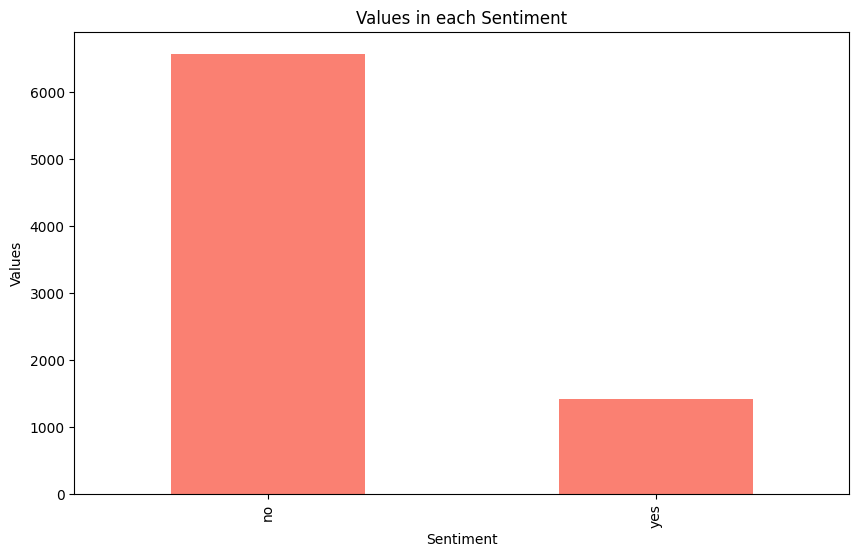

In [7]:
plt.figure(figsize=(10, 6))
data['relevance'].value_counts().plot(kind='bar', color='salmon')
plt.title("Values in each Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Values")
plt.show()


# Text Processing

In [8]:
data['relevance'] = data.relevance.map({'yes':1, 'no':0}) 

In [9]:
data = data[["text","relevance"]] # taking text input and output variable as␣ relevance
data = data[:5000]
data.shape


(5000, 2)

In [10]:
data.head()


,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [11]:
data['text'][0]


'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

# 2 Text Cleaning
2.0.1 Remove named entities.

2.0.2 Convert to lowercase.

2.0.3 Replace “” with a space.

2.0.4 Replace hyphens with spaces.

2.0.5 Remove punctuation and digits.

2.0.6 Remove stopwords.

2.0.7 Apply lemmatization.

In [12]:
pip install stop-words


Note: you may need to restart the kernel to use updated packages.


In [13]:
import spacy #spaCy is a free open-source library for Natural Language Processing in Python. It features NER, POS tagging, dependency parsing, word vectors and more.
from stop_words import get_stop_words
import string

In [14]:
nlp = spacy.load('en_core_web_sm')
stopwords = get_stop_words('en') # Use 'en' for English, adjust for other␣ languages
def clean(doc):
    text_no_namedentities = [] #Named entities refer to the key subjects of a piece of text, such as names, locations, companies, events and products, as well as themes, topics, times, monetary values and percentages.
    document = nlp(doc)
    ents = [e.text for e in document.ents]

    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = " ".join(text_no_namedentities)
    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ")
    doc = doc.replace("-", " ")
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
# Use spaCy lemmatizer
    doc = " ".join([token.lemma_ for token in nlp(doc)])
    return doc


In [15]:
# Test the clean function
cleaned_text = clean(data['text'][0])
print(cleaned_text)




new york yield certificate deposit offer major bank drop tenth percentage point late week reflect overall decline short term interest rate br small denomination consumer cd sell directly bank average yield six month deposit fall week end yesterday accord bank survey money market information service br three month consumer deposit average yield sink week accord bank survey new york pay less small denomination decline somewhat small five year consumer cd ease say br yield three month six month bill sell s auction plummet fifth percentage point previous week respectively


In [16]:
data['text'] = data['text'].apply(clean)
data.head()

,text,relevance
0,new york yield certificate deposit offer major...,1
1,wall street journal online br morning brief lo...,0
2,effort achieve banking reform negotiator admin...,0
3,statistic enormous cost employee drug abuse we...,0
4,new york indecision mark dollar s tone trader ...,1


TF-IDF stands for term frequency-inverse document frequency and it is a measure, 
used in the fields of information retrieval (IR) and machine learning, 
that can quantify the importance or relevance of string representations (words, phrases, lemmas, etc)  
in a document amongst a collection of documents (also known as a corpus).

In [17]:
docs = list(data['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [18]:
X = docs
y = data['relevance']
print(X.shape, y.shape)

(5000, 20000) (5000,)


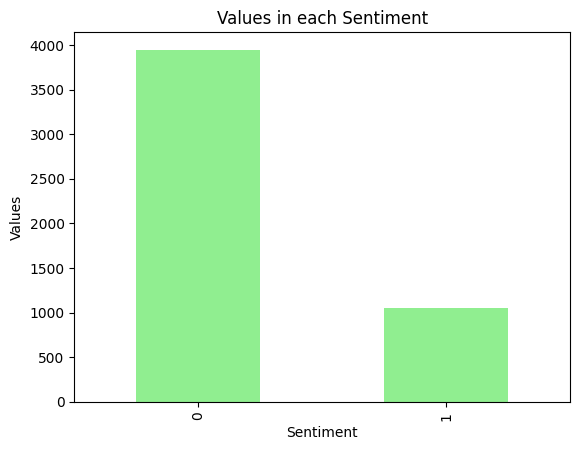

In [19]:
y.value_counts().plot(kind='bar',color="lightgreen")
plt.title("Values in each Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Values")
plt.show()

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2,random_state=123, stratify=y)

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4000, 20000) (4000,)
(1000, 20000) (1000,)


# 4 Naive Bayes Classifier
## 4.1 Gaussian Naive Bayes

In [22]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)


GaussianNB()

In [23]:
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)


In [24]:
print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))


Training Accuracy score: 0.96275
Testing Accuracy score: 0.752


In [25]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_test, target_names=['notrelevant', 'relevant'])
print(report)


              precision    recall  f1-score   support

 notrelevant       0.81      0.90      0.85       789
    relevant       0.34      0.19      0.25       211

    accuracy                           0.75      1000
   macro avg       0.58      0.55      0.55      1000
weighted avg       0.71      0.75      0.72      1000



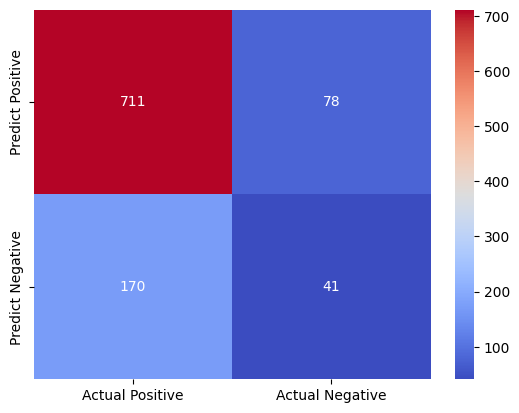

In [26]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.show()


## 4.2 Multinomial Naive Bayes

In [27]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [28]:
y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)

In [29]:
print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

Training Accuracy score: 0.789
Testing Accuracy score: 0.789


In [30]:
result = classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant'])
print(result)

              precision    recall  f1-score   support

not relevant       0.79      1.00      0.88       789
    relevant       0.00      0.00      0.00       211

    accuracy                           0.79      1000
   macro avg       0.39      0.50      0.44      1000
weighted avg       0.62      0.79      0.70      1000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


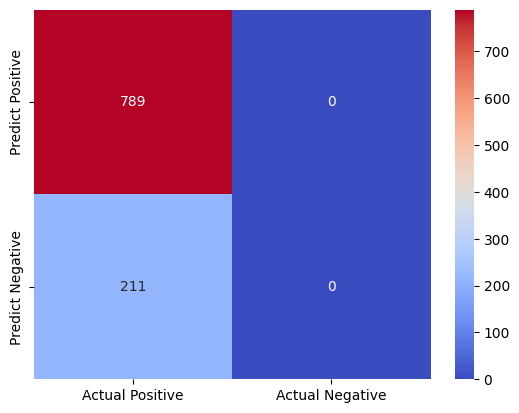

In [31]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.show()


In [32]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [33]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)


In [34]:
print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

Training Accuracy score: 0.83225
Testing Accuracy score: 0.792


In [35]:
results = classification_report(y_test, y_pred_test, target_names=['notrelevant', 'relevant'])
print(results)

              precision    recall  f1-score   support

 notrelevant       0.81      0.97      0.88       789
    relevant       0.53      0.13      0.21       211

    accuracy                           0.79      1000
   macro avg       0.67      0.55      0.55      1000
weighted avg       0.75      0.79      0.74      1000



In [36]:
svc = LinearSVC(class_weight='balanced')
svc.fit(X_train, y_train)


LinearSVC(class_weight='balanced')

In [37]:
y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)


In [38]:
print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

Training Accuracy score: 0.96375
Testing Accuracy score: 0.757


In [39]:
repo = classification_report(y_test, y_pred_test, target_names=['not relevant','relevant'])
print(repo)

              precision    recall  f1-score   support

not relevant       0.86      0.83      0.84       789
    relevant       0.43      0.50      0.46       211

    accuracy                           0.76      1000
   macro avg       0.65      0.66      0.65      1000
weighted avg       0.77      0.76      0.76      1000



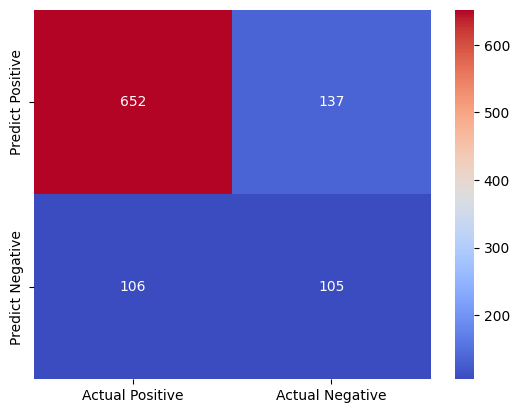

In [40]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.show()


In [41]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [42]:
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))


Training Accuracy score: 1.0
Testing Accuracy score: 0.722


In [43]:
repor = classification_report(y_test, y_pred_test, target_names=['notrelevant', 'relevant'])
print(repor)

              precision    recall  f1-score   support

 notrelevant       0.82      0.83      0.83       789
    relevant       0.33      0.31      0.32       211

    accuracy                           0.72      1000
   macro avg       0.58      0.57      0.57      1000
weighted avg       0.72      0.72      0.72      1000



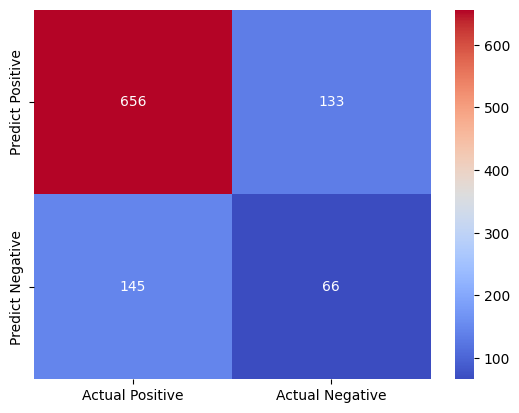

In [44]:
cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.show()


In [45]:
from sklearn.ensemble import VotingClassifier
classifiers = [('Decision Tree', dt),
('Logistic Regression', lr),
('Naive Bayes', gnb)]


In [46]:
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)


VotingClassifier(estimators=[('Decision Tree',
                              DecisionTreeClassifier(random_state=42)),
                             ('Logistic Regression',
                              LogisticRegression(random_state=42)),
                             ('Naive Bayes', GaussianNB())])

In [47]:
y_pred_train=vc.predict(X_train)
y_pred_test = vc.predict(X_test)

In [48]:
print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

Training Accuracy score: 0.99725
Testing Accuracy score: 0.788
